<a href="https://colab.research.google.com/github/NidhiSaini1/Gesture_Recognition/blob/main/comehere_filtered_trimmed_Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Filtering the Gesture Come here and applying the datasets**

# New Section


We've successfully utilized the phyphox app to gather accelerometer data across 8 distinct sets for each defined gesture, including circular motion, waving,come here and waving motion. Ensuring consistency, each gesture was repeated 15 times within each set. For preprocessing, we've eliminated non-essential movement artifacts from the recordings' beginnings and ends using the threshold based elimination. Moreover, we implemented a Butterworth low-pass filter to smooth out the data, significantly reducing high-frequency noise and refining the dataset for subsequent analysis.

Saving Comehere1_N.csv to Comehere1_N (1).csv
Saving Comehere2_N.csv to Comehere2_N (1).csv
Saving Comehere3_N.csv to Comehere3_N (1).csv
Saving ComeHereA2.csv to ComeHereA2 (1).csv
Saving ComeHereA3.csv to ComeHereA3 (1).csv
Saving Raw Data_comehere_1_G.csv to Raw Data_comehere_1_G (1).csv
Saving Raw Data_comehere_2_G.csv to Raw Data_comehere_2_G (1).csv
Saving Raw Data_comehere_3_G.csv to Raw Data_comehere_3_G (1).csv
Processing file: Comehere1_N (1).csv
Processing file: Comehere2_N (1).csv
Processing file: Comehere3_N (1).csv
Processing file: ComeHereA2 (1).csv
Processing file: ComeHereA3 (1).csv
Processing file: Raw Data_comehere_1_G (1).csv
Processing file: Raw Data_comehere_2_G (1).csv
Processing file: Raw Data_comehere_3_G (1).csv


<ipython-input-2-49855c7e16a5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data[filtered_column_name] = butter_lowpass_filter(trimmed_data[column], cutoff_frequency, sampling_rate)
<ipython-input-2-49855c7e16a5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data[filtered_column_name] = butter_lowpass_filter(trimmed_data[column], cutoff_frequency, sampling_rate)
<ipython-input-2-49855c7e16a5>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

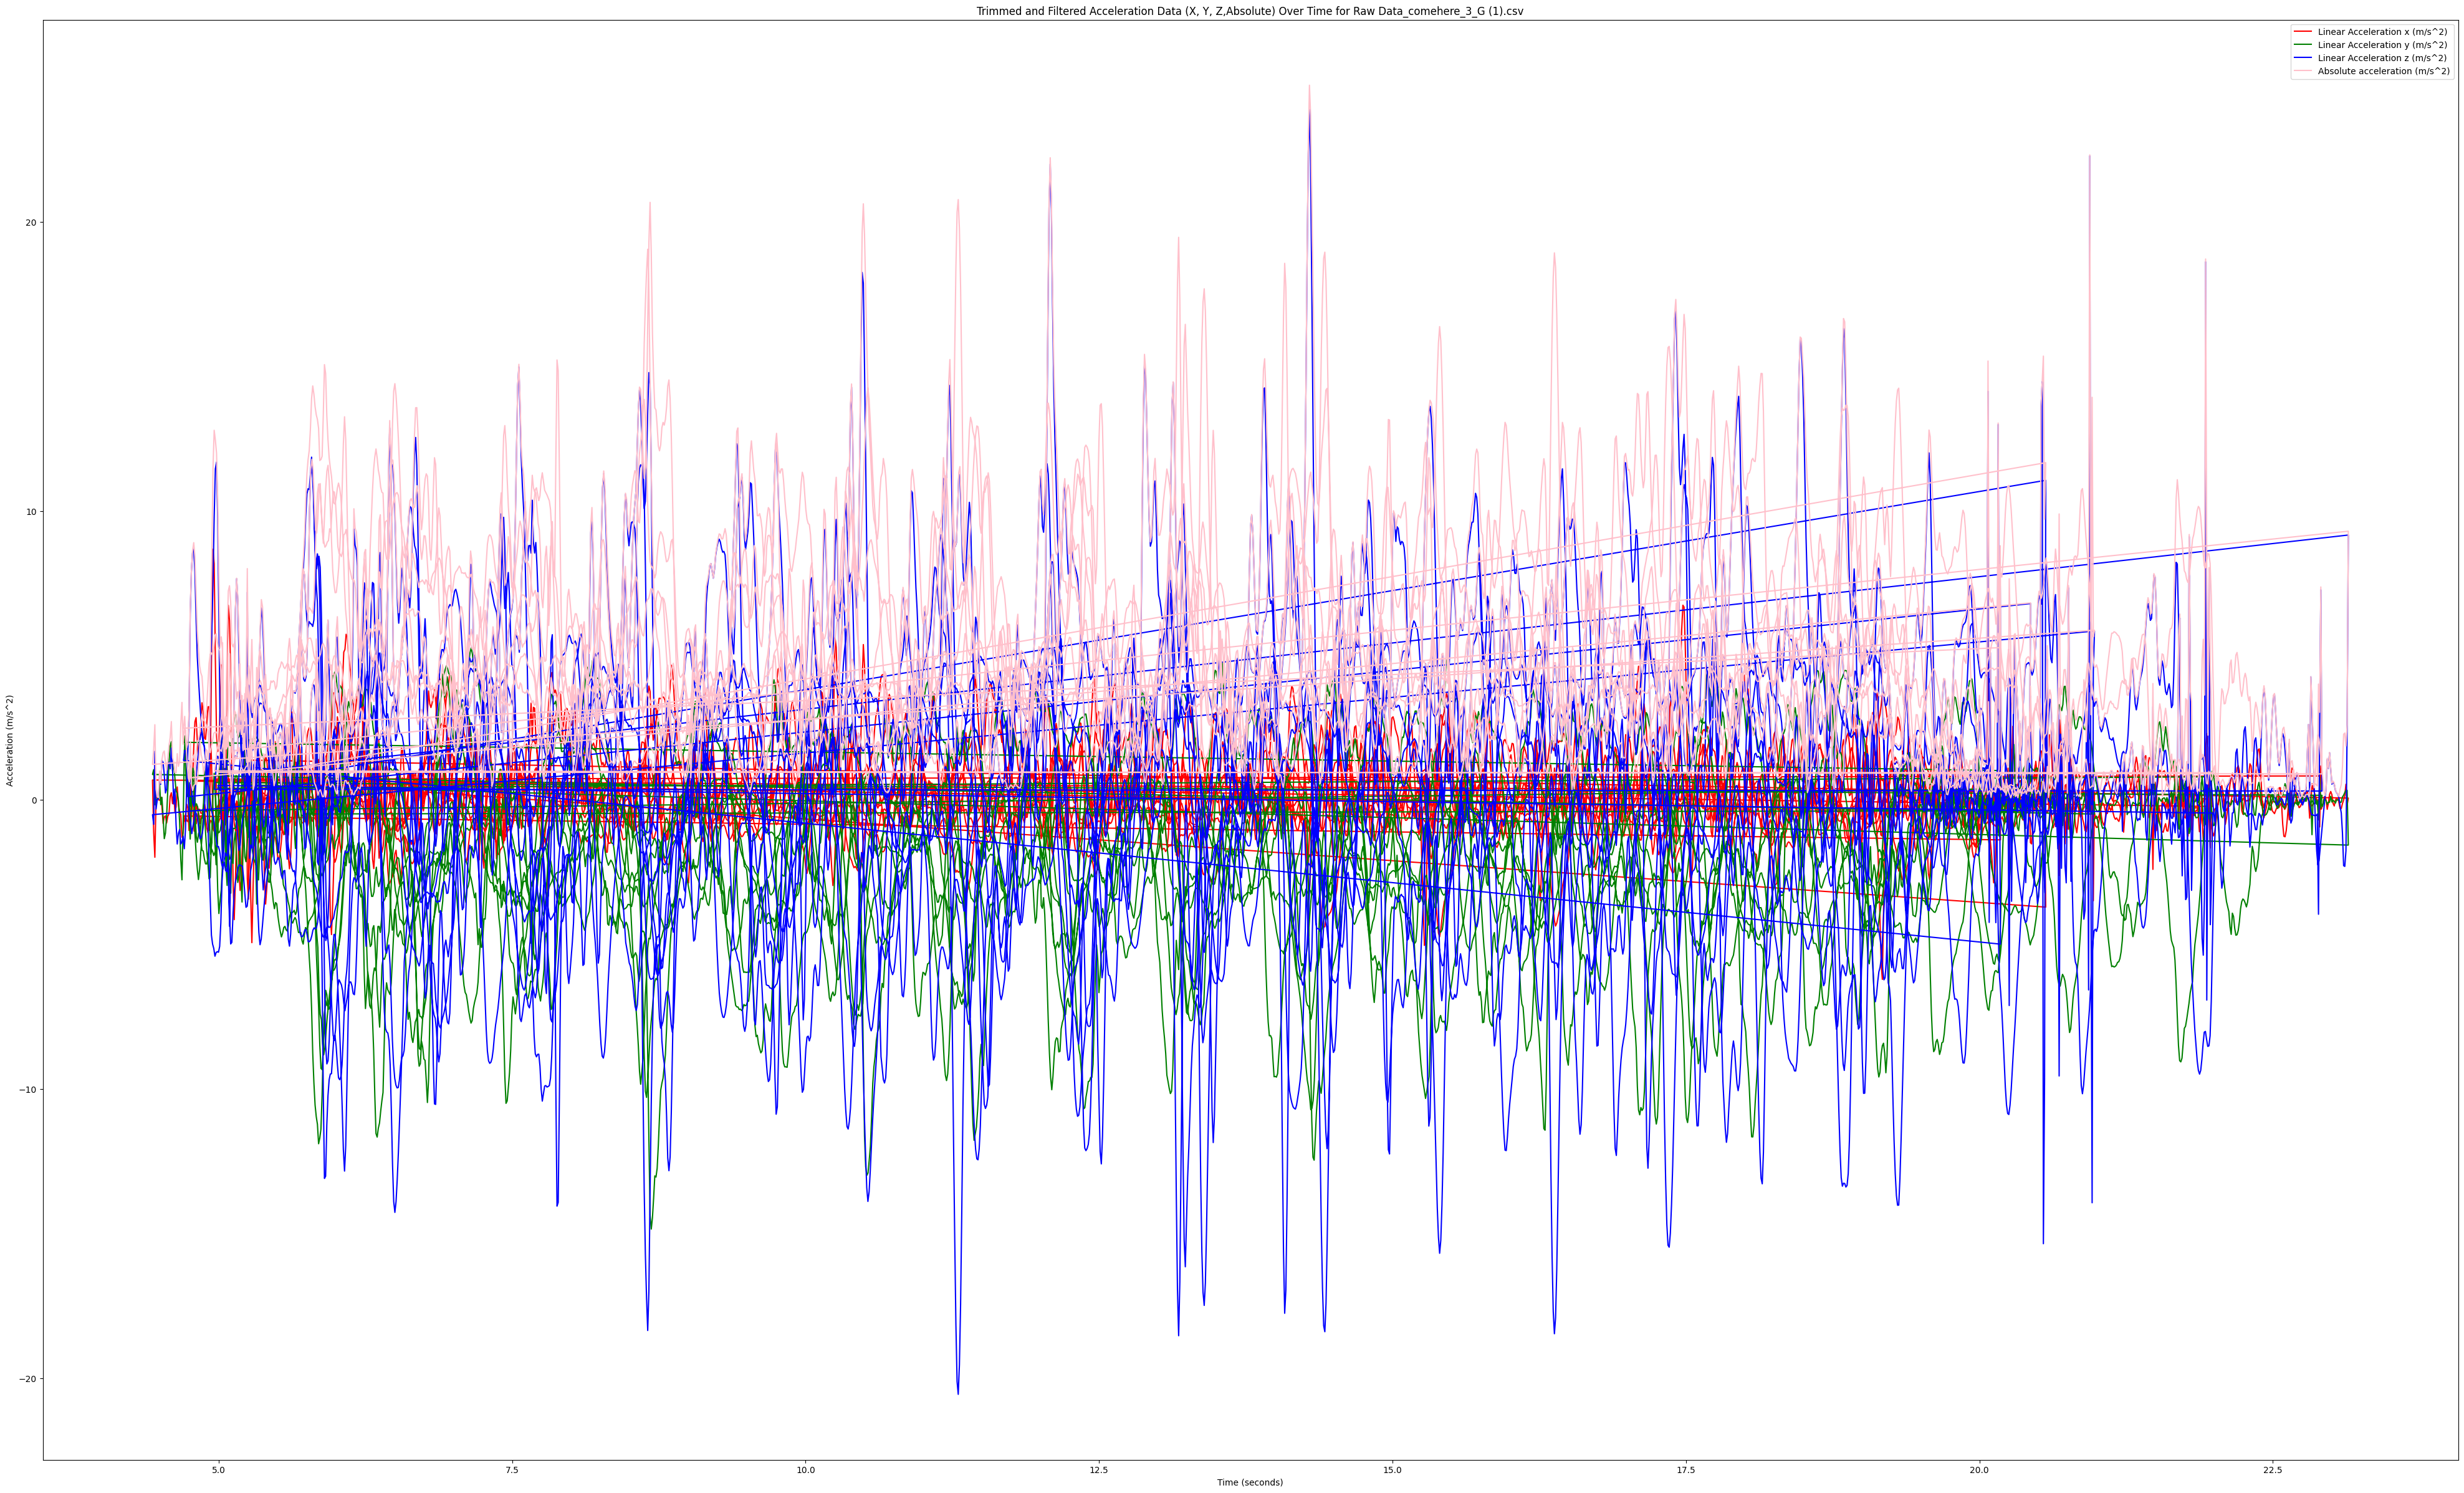

In [2]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import io
from scipy.signal import butter, filtfilt

# Butterworth Filter implementation for smoothening of the peaks
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def trim_and_filter_data(data, cutoff_frequency=2, sampling_rate=100):
    # Defining thresholds for trimming based on standard deviation above mean
    thresholds = {
        'Linear Acceleration x (m/s^2)': data['Linear Acceleration x (m/s^2)'].mean() + data['Linear Acceleration x (m/s^2)'].std(),
        'Linear Acceleration y (m/s^2)': data['Linear Acceleration y (m/s^2)'].mean() + data['Linear Acceleration y (m/s^2)'].std(),
        'Linear Acceleration z (m/s^2)': data['Linear Acceleration z (m/s^2)'].mean() + data['Linear Acceleration z (m/s^2)'].std(),
        'Absolute acceleration (m/s^2)': data['Absolute acceleration (m/s^2)'].mean() + data['Absolute acceleration (m/s^2)'].std()
    }

    start_indices = {column: data[data[column] > threshold].index[0] for column, threshold in thresholds.items()}
    end_indices = {column: data[data[column] > threshold].index[-1] for column, threshold in thresholds.items()}

    # Determining the overall start and end index
    overall_start = min(start_indices.values())
    overall_end = max(end_indices.values())

    # Trimming the data based on the overall indices
    trimmed_data = data.loc[overall_start:overall_end]

    # Applying the filter to each axis of acceleration data and create new columns
    for column in thresholds:
        filtered_column_name = 'Filtered ' + column
        trimmed_data[filtered_column_name] = butter_lowpass_filter(trimmed_data[column], cutoff_frequency, sampling_rate)

    return trimmed_data

# Upload the CSV files from local system
uploaded = files.upload()

# Processing each file and storing the results
all_filtered_data = []
for file_name, data in uploaded.items():
    print(f"Processing file: {file_name}")
    data_df = pd.read_csv(io.BytesIO(data))
    filtered_data = trim_and_filter_data(data_df)
    all_filtered_data.append(filtered_data)

# Merging all filtered dataframes
combined_filtered_data = pd.concat(all_filtered_data, ignore_index=True)

# Plotting the combined data
plt.figure(figsize=(50, 30))
plt.plot(combined_filtered_data['Time (s)'], combined_filtered_data['Linear Acceleration x (m/s^2)'], label='Linear Acceleration x (m/s^2)', linestyle='-', color='r')
plt.plot(combined_filtered_data['Time (s)'], combined_filtered_data['Linear Acceleration y (m/s^2)'], label='Linear Acceleration y (m/s^2)', linestyle='-', color='g')
plt.plot(combined_filtered_data['Time (s)'], combined_filtered_data['Linear Acceleration z (m/s^2)'], label='Linear Acceleration z (m/s^2)', linestyle='-', color='b')
plt.plot(combined_filtered_data['Time (s)'], combined_filtered_data['Absolute acceleration (m/s^2)'], label='Absolute acceleration (m/s^2)', linestyle='-', color='pink')
plt.title(f'Trimmed and Filtered Acceleration Data (X, Y, Z,Absolute) Over Time for {file_name}')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.show()


Feature Engineering

In [3]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, welch
from scipy.fft import fft

def sliding_window(data, window_size, step_size):
    """ Generates overlapping windows with the given size and step size. """
    num_samples = len(data)
    windows = []
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return windows

def calculate_features(windows, fs):
    """ Calculate statistical and advanced features for each window. """
    features_list = []

    for window in windows:
        features = {}
        # Extract data for each axis
        x = window['Filtered Linear Acceleration x (m/s^2)']
        y = window['Filtered Linear Acceleration y (m/s^2)']
        z = window['Filtered Linear Acceleration z (m/s^2)']

        # Calculate features for each axis
        for axis, data in zip(['x', 'y', 'z'], [x, y, z]):
            features[f'mean_{axis}'] = np.mean(data)
            features[f'std_{axis}'] = np.std(data)
            features[f'min_{axis}'] = np.min(data)
            features[f'max_{axis}'] = np.max(data)
            features[f'skew_{axis}'] = pd.Series(data).skew()
            features[f'kurtosis_{axis}'] = pd.Series(data).kurt()

            # Zero-Crossing Rate
            zero_crossings = len(np.where(np.diff(np.signbit(data)))[0])
            features[f'zcr_{axis}'] = zero_crossings / len(data)

            # Frequency-domain features using FFT
            fft_vals = fft(data.values)
            fft_freq = np.fft.fftfreq(len(data), d=1/fs)
            features[f'fft_peak_freq_{axis}'] = fft_freq[np.argmax(np.abs(fft_vals))]
            features[f'fft_peak_magnitude_{axis}'] = np.max(np.abs(fft_vals))

            # Spectral Energy
            f, Pxx = welch(data, fs=fs)
            features[f'spectral_energy_{axis}'] = np.sum(Pxx)

        # Signal Magnitude Area (SMA)
        features['sma'] = np.mean(np.abs(x) + np.abs(y) + np.abs(z))

        # Signal Vector Magnitude (SVM)
        features['svm'] = np.mean(np.sqrt(x**2 + y**2 + z**2))

        #Labelling the data
        features['gesture'] = 3 #come here gesture

        features_list.append(features)

    return pd.DataFrame(features_list)

# Parameters
window_length_seconds = 2
sampling_rate = 100  # As defined earlier
window_size = window_length_seconds * sampling_rate
overlap_size = window_size // 2

# Assuming 'combined_filtered_data' is your DataFrame
windows = sliding_window(combined_filtered_data, window_size, overlap_size)
features_df = calculate_features(windows, sampling_rate)

print(features_df.head())


features_df.to_csv('/content/ComehereFeatures.csv')



/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


     mean_x     std_x     min_x     max_x    skew_x  kurtosis_x  zcr_x  \
0  0.050692  0.629780 -1.374736  1.067672 -0.610532   -0.412884  0.025   
1  0.227655  0.375310 -0.614729  0.895707 -0.597681   -0.162324  0.020   
2  0.129613  0.443336 -0.960450  0.895707 -0.777620    0.215637  0.015   
3 -0.031745  0.425230 -0.960450  0.574459 -0.669090   -0.622498  0.025   
4 -0.043631  0.332329 -0.774197  0.468785 -0.577734   -0.753830  0.035   

   fft_peak_freq_x  fft_peak_magnitude_x  spectral_energy_x  ...     max_z  \
0              1.0             60.067995           1.145206  ...  6.590671   
1              0.0             45.530960           0.383053  ...  6.590671   
2              2.0             34.963103           0.736045  ...  6.072587   
3              1.5             34.173020           0.372964  ...  6.072587   
4              1.5             33.036141           0.143747  ...  5.403084   

     skew_z  kurtosis_z  zcr_z  fft_peak_freq_z  fft_peak_magnitude_z  \
0 -0.350981  